In [1]:
import paddle
import paddle.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

print(paddle.__version__)


2.4.2


In [2]:
import paddle.vision.transforms as T
transform = T.Compose([T.Transpose((2, 0, 1))])

cifar10_train = paddle.vision.datasets.Cifar10(mode='train', transform=transform)
x_train = np.zeros((50000, 3, 32, 32))
y_train = np.zeros((50000, 1), dtype='int32')

for i in range(len(cifar10_train)):
    train_image, train_label = cifar10_train[i]
    
    # normalize the data
    x_train[i,:, :, :] = train_image / 255.
    y_train[i, 0] = train_label

y_train = np.squeeze(y_train)

print(x_train.shape)
print(y_train.shape)


(50000, 3, 32, 32)
(50000,)


In [3]:
cifar10_test = paddle.vision.datasets.cifar.Cifar10(mode='test', transform=transform)
x_test = np.zeros((10000, 3, 32, 32), dtype='float32')
y_test = np.zeros((10000, 1), dtype='int64')

for i in range(len(cifar10_test)):
    test_image, test_label = cifar10_test[i]
   
    # normalize the data
    x_test[i,:, :, :] = test_image / 255.
    y_test[i, 0] = test_label

y_test = np.squeeze(y_test)

print(x_test.shape)
print(y_test.shape)


(10000, 3, 32, 32)
(10000,)


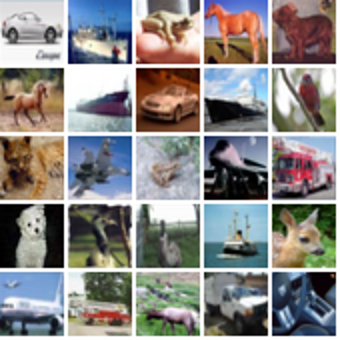

In [4]:
height_width = 32

def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(255, 255, 255),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            array = array.transpose(1,2,0)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage

sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)


In [5]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)


In [6]:
num_classes = 10

def reader_creator(num_batchs):
    def reader():
        iter_step = 0
        while True:
            if iter_step >= num_batchs:
                break
            iter_step += 1
            x = np.empty((2, num_classes, 3, height_width, height_width), dtype=np.float32)
            for class_idx in range(num_classes):
                examples_for_class = class_idx_to_train_idxs[class_idx]
                anchor_idx = random.choice(examples_for_class)
                positive_idx = random.choice(examples_for_class)
                while positive_idx == anchor_idx:
                    positive_idx = random.choice(examples_for_class)
                x[0, class_idx] = x_train[anchor_idx]
                x[1, class_idx] = x_train[positive_idx]
            yield x

    return reader


# num_batchs: how many batchs to generate
def anchor_positive_pairs(num_batchs=100):
    return reader_creator(num_batchs)


(2, 10, 3, 32, 32)


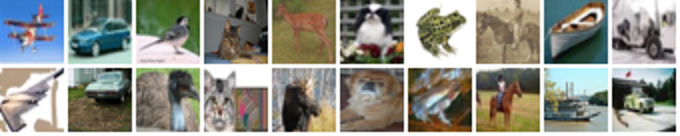

In [7]:
pairs_train_reader = anchor_positive_pairs(num_batchs=1000)
examples = next(pairs_train_reader())
print(examples.shape)
show_collage(examples)


In [8]:
class MyNet(paddle.nn.Layer):
    def __init__(self):
        super(MyNet, self).__init__()

        self.conv1 = paddle.nn.Conv2D(in_channels=3, 
                                      out_channels=32, 
                                      kernel_size=(3, 3),
                                      stride=2)
         
        self.conv2 = paddle.nn.Conv2D(in_channels=32, 
                                      out_channels=64, 
                                      kernel_size=(3,3), 
                                      stride=2)       
        
        self.conv3 = paddle.nn.Conv2D(in_channels=64, 
                                      out_channels=128, 
                                      kernel_size=(3,3),
                                      stride=2)
       
        self.gloabl_pool = paddle.nn.AdaptiveAvgPool2D((1,1))

        self.fc1 = paddle.nn.Linear(in_features=128, out_features=8)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.gloabl_pool(x)
        x = paddle.squeeze(x, axis=[2, 3])
        x = self.fc1(x)
        x = x / paddle.norm(x, axis=1, keepdim=True)
        return x


In [9]:
def train(model):
    print('start training ... ')
    model.train()

    inverse_temperature = paddle.to_tensor(np.array([1.0/0.2], dtype='float32'))

    epoch_num = 20
    
    opt = paddle.optimizer.Adam(learning_rate=0.0001,
                                parameters=model.parameters())
    
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(pairs_train_reader()):
            anchors_data, positives_data = data[0], data[1]

            anchors = paddle.to_tensor(anchors_data)
            positives = paddle.to_tensor(positives_data)
            
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            
            similarities = paddle.matmul(anchor_embeddings, positive_embeddings, transpose_y=True) 
            similarities = paddle.multiply(similarities, inverse_temperature)
            
            sparse_labels = paddle.arange(0, num_classes, dtype='int64')

            loss = F.cross_entropy(similarities, sparse_labels)
            
            if batch_id % 500 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            loss.backward()
            opt.step()
            opt.clear_grad()

model = MyNet()
train(model)


start training ... 
epoch: 0, batch_id: 0, loss is: [2.2883608]


epoch: 0, batch_id: 500, loss is: [1.9710315]
epoch: 1, batch_id: 0, loss is: [1.9878576]
epoch: 1, batch_id: 500, loss is: [2.1239727]
epoch: 2, batch_id: 0, loss is: [1.8363768]
epoch: 2, batch_id: 500, loss is: [2.054016]
epoch: 3, batch_id: 0, loss is: [2.2109954]
epoch: 3, batch_id: 500, loss is: [1.9235306]
epoch: 4, batch_id: 0, loss is: [2.6208317]
epoch: 4, batch_id: 500, loss is: [1.6852318]
epoch: 5, batch_id: 0, loss is: [1.9793785]
epoch: 5, batch_id: 500, loss is: [2.0231345]
epoch: 6, batch_id: 0, loss is: [1.8643917]
epoch: 6, batch_id: 500, loss is: [1.8150219]
epoch: 7, batch_id: 0, loss is: [1.7392269]
epoch: 7, batch_id: 500, loss is: [1.8646969]
epoch: 8, batch_id: 0, loss is: [1.807429]
epoch: 8, batch_id: 500, loss is: [2.0384583]
epoch: 9, batch_id: 0, loss is: [2.015884]
epoch: 9, batch_id: 500, loss is: [1.8069214]
epoch: 10, batch_id: 0, loss is: [2.0118804]
epoch: 10, batch_id: 500, loss is: [2.2373137]
epoch: 11, batch_id: 0, loss is: [1.8622179]
epoch: 11,

In [10]:
near_neighbours_per_example = 10

x_test_t = paddle.to_tensor(x_test)
test_images_embeddings = model(x_test_t)
similarities_matrix = paddle.matmul(test_images_embeddings, test_images_embeddings, transpose_y=True) 

indicies = paddle.argsort(similarities_matrix, descending=True)
indicies = indicies.numpy()


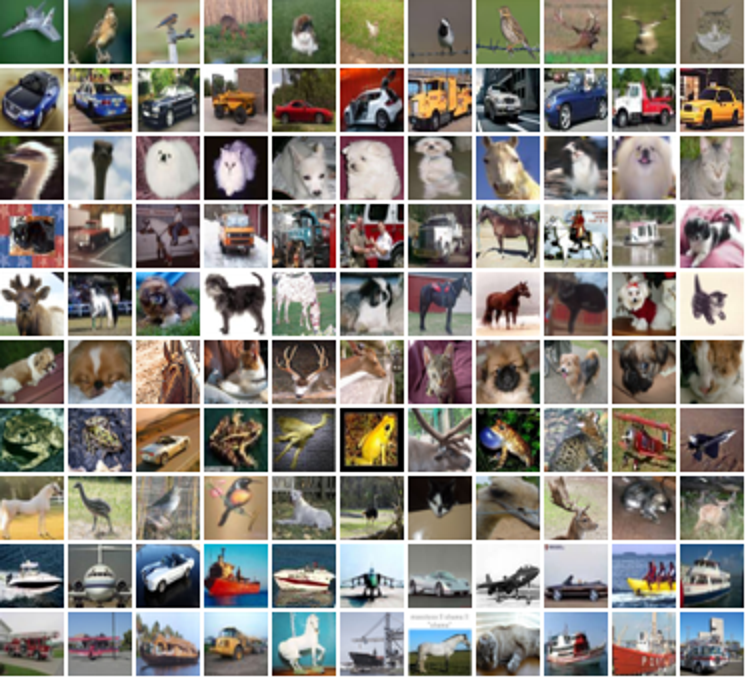

In [11]:
examples = np.empty(
    (
        num_classes,
        near_neighbours_per_example + 1,
        3,
        height_width,
        height_width,
    ),
    dtype=np.float32,
)

for row_idx in range(num_classes):
    examples_for_class = class_idx_to_test_idxs[row_idx]
    anchor_idx = random.choice(examples_for_class)
    
    examples[row_idx, 0] = x_test[anchor_idx]
    anchor_near_neighbours = indicies[anchor_idx][1:near_neighbours_per_example+1]
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_collage(examples)
